In [1]:
# !jt -t monokai -ofs 10 -dfs 8 -cellw 90%

In [2]:
import os
import sys
import numpy as np
import pandas as pd
import json
import re
import pathlib
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler

In [3]:
complexes = []
dir = "/media/hdd1/roproQ3drew"
dirs = os.listdir(dir)
for dr in dirs:
    if os.path.isdir(dir+'/'+dr):
        if re.search(r'\b\w{4}\b', dr):
            data = dir+'/'+dr+'/'+dr+"_TOTAL.json"
            if os.path.exists(data):
                complexes.append(dr)
print("we have Processed %d datasets"%len(complexes))                

we have Processed 441 datasets


In [4]:
df_total = pd.DataFrame()
for cmplx in complexes:
    df = pd.read_json(dir+'/'+cmplx+'/'+cmplx+'_TOTAL.json')
    df = df[df.complex != 1]    
#     df.loc[df.complex == 0, 'method'] = 'CDR'
#     df.loc[df.complex == 0, 'zrank'] = df['zrank'].mean()
    df = df[df.complex != 0]
    df = df[df.ProQ3D > 0.0]
    df.reset_index(drop=True, inplace=True)
    df.drop(['structure','method', 'name','H1_cluster', 'complex',
           'H1_distance', 'H1_sequence', 'H2_cluster', 'H2_distance', 'nres_all', 'ref',
           'H2_sequence', 'H3_cluster', 'H3_distance', 'H3_sequence', 'L1_cluster',
           'L1_distance', 'L1_sequence', 'L2_cluster', 'L2_distance',
           'L2_sequence', 'L3_cluster', 'L3_distance', 'L3_sequence'], axis=1, inplace=True)
#     mm = MinMaxScaler()
#     df_scaled = pd.DataFrame(mm.fit_transform(df),columns = df.columns)
#     df_scaled.columns = [str(col) + '_scaled' for col in df.columns]
#     df_scaled.drop(['rmsd_scaled'], axis=1, inplace=True)
#     df = df.join(df_scaled)
    df_total = df_total.append(df, ignore_index=True)
    df_total.dropna(inplace=True)    


In [5]:
df_total.loc[df_total.rmsd <= 2.0, 'docked'] = True
df_total.loc[df_total.rmsd > 2.0, 'docked'] = False
df_docked = df_total.loc[df_total.rmsd <=2.0]
df_total.drop(['rmsd'], axis=1, inplace=True)
df_total.docked = df_total.docked.astype(int)

In [6]:
len(df_total.columns)

41

In [7]:
df_total.columns

Index(['zrank', 'ProQ2D', 'ProQRosCenD', 'ProQRosFAD', 'ProQ3D',
       'complex_normalized', 'dG_separated', 'dG_separated/dSASAx100',
       'dSASA_hphobic', 'dSASA_int', 'dSASA_polar', 'delta_unsatHbonds',
       'hbond_E_fraction', 'hbonds_int', 'nres_int', 'per_residue_energy_int',
       'sc_value', 'side1_normalized', 'side1_score', 'side2_normalized',
       'side2_score', 'fa_atr', 'fa_rep', 'fa_sol', 'fa_intra_rep',
       'fa_intra_sol_xover4', 'lk_ball_wtd', 'fa_elec', 'pro_close',
       'hbond_sr_bb', 'hbond_lr_bb', 'hbond_bb_sc', 'hbond_sc', 'dslf_fa13',
       'omega', 'fa_dun', 'p_aa_pp', 'yhh_planarity', 'rama_prepro',
       'total_score', 'docked'],
      dtype='object')

In [8]:
df_total.docked.value_counts()

0    35325
1     5962
Name: docked, dtype: int64

In [9]:
corr_matrix = df_total.corr()
corr_matrix['docked'].sort_values(ascending=True)

dG_separated             -0.526742
dG_separated/dSASAx100   -0.469950
zrank                    -0.356366
side1_score              -0.222089
per_residue_energy_int   -0.219682
side2_normalized         -0.209369
side2_score              -0.207272
complex_normalized       -0.142039
rama_prepro              -0.092578
side1_normalized         -0.092179
fa_intra_rep             -0.068957
fa_intra_sol_xover4      -0.063677
fa_rep                   -0.063190
fa_dun                   -0.059864
fa_sol                   -0.058515
omega                    -0.040535
pro_close                -0.017732
hbond_sc                 -0.005234
hbond_E_fraction         -0.001837
yhh_planarity             0.005959
ProQ2D                    0.008551
hbond_lr_bb               0.013677
delta_unsatHbonds         0.026568
dslf_fa13                 0.032364
total_score               0.036786
hbond_bb_sc               0.037447
ProQRosCenD               0.037461
fa_elec                   0.045216
ProQRosFAD          

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [11]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(df_total, df_total['docked']):
    strat_train_set = df_total.loc[train_index]
    strat_test_set = df_total.loc[test_index]

In [12]:
print(strat_train_set.docked.value_counts()/ len(strat_train_set))
print(strat_test_set.docked.value_counts()/ len(strat_test_set))

0    0.855581
1    0.144419
Name: docked, dtype: float64
0    0.855655
1    0.144345
Name: docked, dtype: float64


In [13]:
# X_train_prep = strat_train_set.drop("docked", axis=1)
# y_train = strat_train_set["docked"].copy()
# X_test_prep = strat_test_set.drop("docked", axis=1)
# y_test = strat_test_set["docked"].copy()

In [14]:
X_train = strat_train_set.drop("docked", axis=1)
y_train = strat_train_set["docked"].copy()
X_test = strat_test_set.drop("docked", axis=1)
y_test = strat_test_set["docked"].copy()

In [15]:
# ss = StandardScaler()
# X_train = ss.fit_transform(X_train_prep)
# X_test = ss.fit_transform(X_test_prep)
y_train_1 = (y_train == 1)
y_test_1 = (y_test == 1)

In [16]:
from sklearn import svm

In [17]:
clf = svm.SVC(gamma=0.001, C=100.)
clf.fit(X_train, y_train_1)

SVC(C=100.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [18]:
from sklearn.model_selection import cross_val_score

In [19]:
cross_val_score(clf, X_train, y_train_1, cv=10, scoring="accuracy")

array([0.88767787, 0.88283379, 0.88404481, 0.88586134, 0.88465032,
       0.89040266, 0.88283379, 0.88283379, 0.88919164, 0.88582677])

In [20]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
sgd_clf.fit(X_train, y_train_1)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [21]:
cross_val_score(sgd_clf, X_train, y_train_1, cv=10, scoring="accuracy")

array([0.25370875, 0.89887981, 0.77535574, 0.89585226, 0.89857705,
       0.90251287, 0.86315471, 0.92037542, 0.89706328, 0.91429437])

In [22]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(clf, X_train, y_train_1, cv=3)

In [23]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_1, y_train_pred)

array([[28240,    19],
       [ 3924,   846]])

In [24]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_1, y_train_pred)

0.9780346820809248

In [25]:
recall_score(y_train_1, y_train_pred)

0.17735849056603772

In [26]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_1, cv=3,
                             method="decision_function")

In [27]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_1, y_scores)

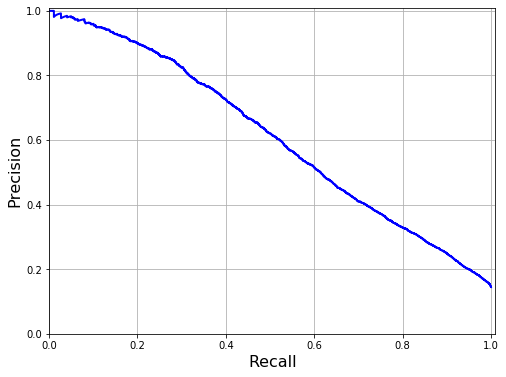

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1.01, 0, 1.01])
    plt.grid(True)

plt.figure(figsize=(8, 6), facecolor="white")
plot_precision_vs_recall(precisions, recalls)
plt.show()

In [29]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_1, y_scores)

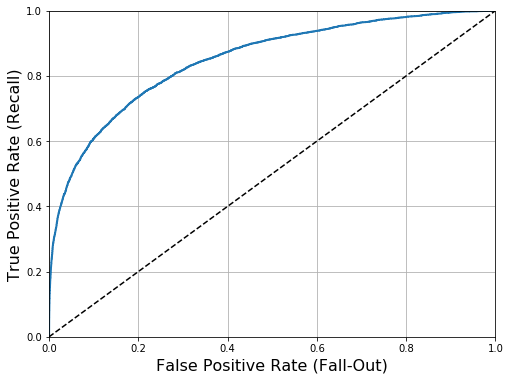

In [30]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    # Not shown in the book
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) # Not shown
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    # Not shown
    plt.grid(True)                                            # Not shown

plt.figure(figsize=(8, 6), facecolor="white")               # Not shown
plot_roc_curve(fpr, tpr)
plt.show()

In [31]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_1, y_scores)

0.849702233970395

In [32]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_1, cv=3,
                                    method="predict_proba")

In [33]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_1, y_scores_forest)

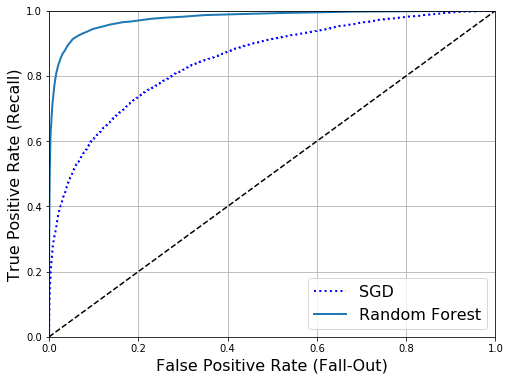

In [34]:
plt.figure(figsize=(8, 6), facecolor="white")
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)
plt.show()

In [35]:
roc_auc_score(y_train_1, y_scores_forest)

0.97660253763796

In [36]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

In [37]:
xgb_clf = XGBClassifier(objective= 'binary:logistic', nthread=16, seed=42)
xgb_clf.fit(X_train, y_train_1)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=16, nthread=16, num_parallel_tree=1,
              objective='binary:logistic', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=42, subsample=1,
              tree_method=None, validate_parameters=False, verbosity=None)

In [38]:
parameters = {
    'max_depth': range (2, 10, 1),
    'n_estimators': range(60, 220, 40),
    'learning_rate': [0.1, 0.01, 0.05]
}

In [52]:
parameters = {'nthread':[16], #when use hyperthread, xgboost may become slower
                        'objective':['binary:logistic'],
#                         'booster':[None, dart],
                        'learning_rate': [0.05], #so called `eta` value
                        'max_depth': [9],
                        'n_estimators': [1200, 1400, 1600],
                        'min_child_weight': [1],
                        'silent': [1],
                        'subsample': [0.7, 0.5],
                        'colsample_bytree': [0.7]}

In [53]:
grid_search = GridSearchCV(
    estimator=xgb_clf,
    param_grid=parameters,
    scoring = 'roc_auc',
    n_jobs = 16,
    cv = 10,
    verbose=True
)

In [54]:
grid_search.fit(X_train, y_train)

Fitting 10 folds for each of 6 candidates, totalling 60 fits


[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed: 14.0min
[Parallel(n_jobs=16)]: Done  60 out of  60 | elapsed: 32.5min finished


GridSearchCV(cv=10, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster=None,
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0, gpu_id=-1,
                                     importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=0.300000012,
                                     max_delta_step=0, max_depth=6,
                                     min_child_weight=1, missing=nan,
                                     monotone_constraints=None,
                                     n_estimators=100, n_jobs...
                                     validate_parameters=False,
                                     verbosity=None),
             iid='deprecated', n_jobs=16,
             param_grid={'colsample_bytree': [0.7], 'learning_rate': [0.05],
                         'max_depth': [9], 'm

In [55]:
final_xgb = grid_search.best_estimator_
final_xgb

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.05, max_delta_step=0, max_depth=9,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=1600, n_jobs=16, nthread=16, num_parallel_tree=1,
              objective='binary:logistic', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=42, silent=1,
              subsample=0.7, tree_method=None, validate_parameters=False,
              verbosity=None)

In [56]:
import pickle
# #save
pickle.dump(final_xgb, open("final_xgb_class.dat", "wb"))

In [57]:
# load
final_xgb_loaded = pickle.load(open("final_xgb_class.dat", "rb"))

In [58]:
print(final_xgb_loaded)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.05, max_delta_step=0, max_depth=9,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=1600, n_jobs=16, nthread=16, num_parallel_tree=1,
              objective='binary:logistic', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=42, silent=1,
              subsample=0.7, tree_method=None, validate_parameters=False,
              verbosity=None)


In [59]:
# final_xgb_loaded = XGBClassifier(base_score=0.5, colsample_bylevel=1,
#               colsample_bynode=1, colsample_bytree=0.7, gamma=0, gpu_id=-1,
#               importance_type='gain', interaction_constraints=None,
#               learning_rate=0.05, max_delta_step=0, max_depth=7,
#               min_child_weight=1, monotone_constraints=None,
#               n_estimators=660, n_jobs=16, nthread=16, num_parallel_tree=1,
#               objective='binary:logistic', random_state=42, reg_alpha=0,
#               reg_lambda=1, scale_pos_weight=1, seed=42, silent=1,
#               subsample=0.7, tree_method=None, validate_parameters=False,
#               verbosity=None)
# final_xgb_loaded.fit(X_train, y_train_1)

In [60]:
# import pickle
# pickle.dump(final_xgb_loaded, open("final_xgb_class.dat", "wb"))

In [61]:
# cross_val_score(final_xgb_loaded, X_train, y_train_1, cv=10, scoring="accuracy")

In [62]:
final_xgb_loaded.feature_names = list(X_train.columns)
final_xgb_loaded.get_booster().feature_names = final_xgb_loaded.feature_names

In [63]:
from collections import OrderedDict
fnum = 20
booster = final_xgb_loaded.get_booster()
gain = booster.get_score(importance_type="gain")
gain_top = pd.DataFrame([OrderedDict(sorted(gain.items(), key=lambda x: x[1], reverse=True)[:fnum])])
weight = booster.get_score(importance_type="weight")
weight_top = pd.DataFrame([OrderedDict(sorted(weight.items(), key=lambda x: x[1], reverse=True)[:fnum])])
cover = booster.get_score(importance_type="cover")
cover_top = pd.DataFrame([OrderedDict(sorted(cover.items(), key=lambda x: x[1], reverse=True)[:fnum])])

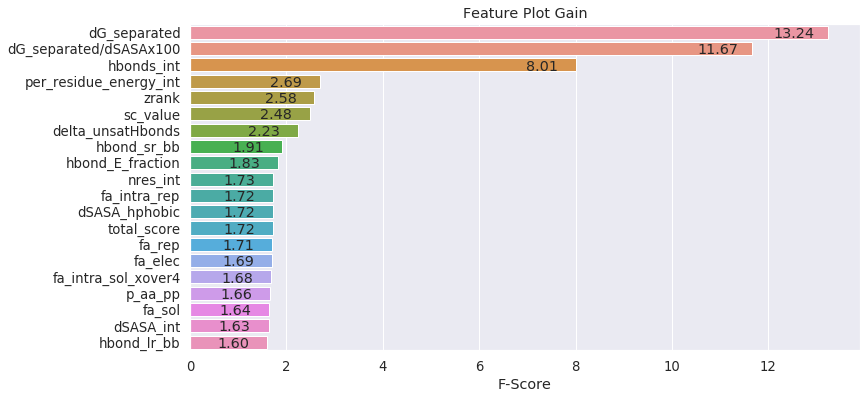

In [64]:
sns.set(font_scale=1.2)
f, ax = plt.subplots(figsize=(12, 6), facecolor="white")
ax.set(xlabel='F-Score')
plt.title('Feature Plot Gain')
sns.barplot(data=gain_top, orient='h')
for p in ax.patches:
    width = p.get_width()
    ax.text(width -0.7  ,
            p.get_y()+p.get_height()/2. + 0.34,
            '{:1.2f}'.format(width),
            ha="center")

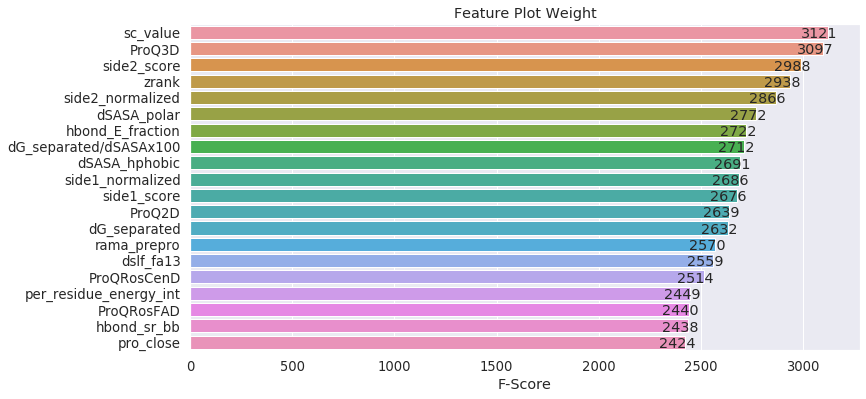

In [65]:
f, ax = plt.subplots(figsize=(12, 6), facecolor="white")
ax.set(xlabel='F-Score')
plt.title('Feature Plot Weight')
sns.barplot(data=weight_top, orient='h')
for p in ax.patches:
    width = p.get_width()
    ax.text(width -40  ,
            p.get_y()+p.get_height()/1. + -0.05,
            '{:1.0f}'.format(width),
            ha="center")

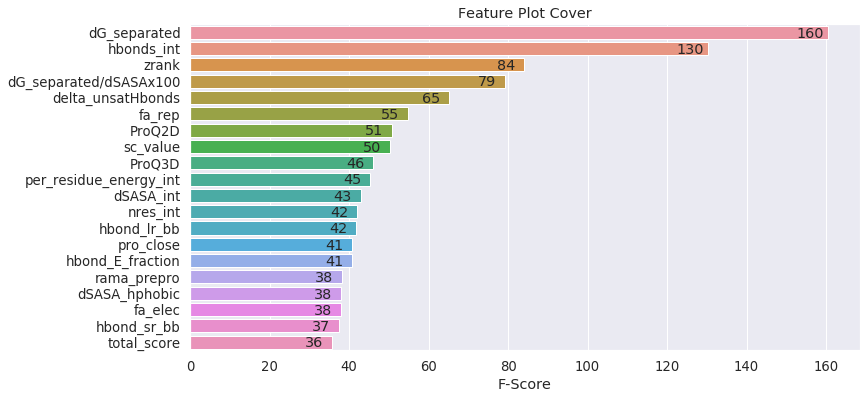

In [66]:
f, ax = plt.subplots(figsize=(12, 6), facecolor="white")
ax.set(xlabel='F-Score')
plt.title('Feature Plot Cover')
sns.barplot(data=cover_top, orient='h')
for p in ax.patches:
    width = p.get_width()
    ax.text(width -4.5  ,
            p.get_y()+p.get_height()/2. + 0.32,
            '{:1.0f}'.format(width),
            ha="center")

In [67]:
# from xgboost import plot_importance
# plt.rcParams["figure.figsize"] = [14,8]
# plt.rcParams['figure.facecolor'] = 'white'
# final_xgb_loaded.get_booster().feature_names = final_xgb_loaded.feature_names
# plot_importance(final_xgb_loaded.get_booster(),
#                 max_num_features=15, title='Feature importance Weight', 
#                 grid=False)
# plt.show()

In [68]:
# cvres = grid_search.cv_results_
# # for key, value in grid_search.cv_results_.items() :
# #     print (key)

# for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
#     print(mean_score, params)

In [69]:
y_probas_xgb = cross_val_predict(final_xgb_loaded, X_train, y_train_1, cv=10,
                                 method="predict_proba")

In [70]:
y_scores_xgb = y_probas_xgb[:, 1] # score = proba of positive class
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(y_train_1, y_scores_xgb)

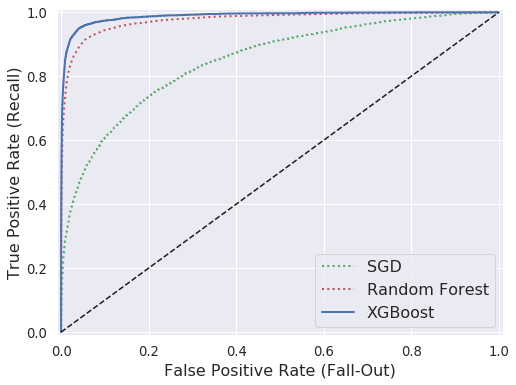

In [71]:
plt.figure(figsize=(8, 6), facecolor="white")
plt.plot(fpr, tpr, "g:", linewidth=2, label="SGD")
plt.plot(fpr_forest, tpr_forest, "r:", linewidth=2, label="Random Forest")
plot_roc_curve(fpr_xgb, tpr_xgb, "XGBoost")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)
plt.axis([-0.01, 1.01, -0.01, 1.01])
plt.show()


In [72]:
train_roc = roc_auc_score(y_train_1, y_scores_xgb)

In [73]:
y_probas_xgb_test = cross_val_predict(final_xgb_loaded, X_test, y_test, cv=3,
                                     method="predict_proba")

In [74]:
precisions, recalls, thresholds = precision_recall_curve(y_train_1, y_scores_xgb)

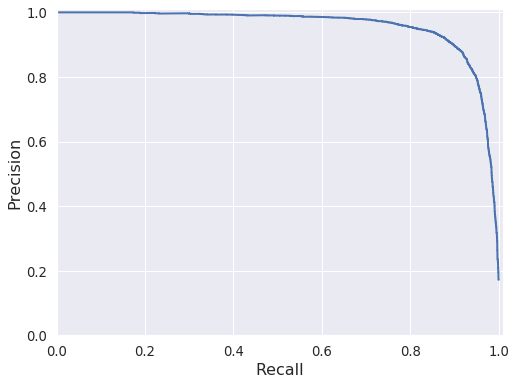

In [75]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1.01, 0, 1.01])
    plt.grid(True)

plt.figure(figsize=(8, 6), facecolor="white")
plot_precision_vs_recall(precisions, recalls)
plt.show()

In [76]:
y_scores_xgb_test = y_probas_xgb_test[:, 1] # score = proba of positive class
fpr_xgb_t, tpr_xgb_t, thresholds_xgb_t = roc_curve(y_test, y_scores_xgb_test)

In [77]:
test_roc = roc_auc_score(y_test, y_scores_xgb_test)

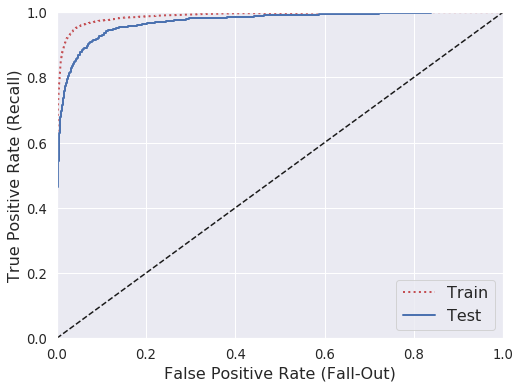

In [78]:
plt.figure(figsize=(8, 6), facecolor="white")
plt.plot(fpr_xgb, tpr_xgb, "r:", linewidth=2, label="Train")
plot_roc_curve(fpr_xgb_t, tpr_xgb_t, "Test")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)
plt.show()

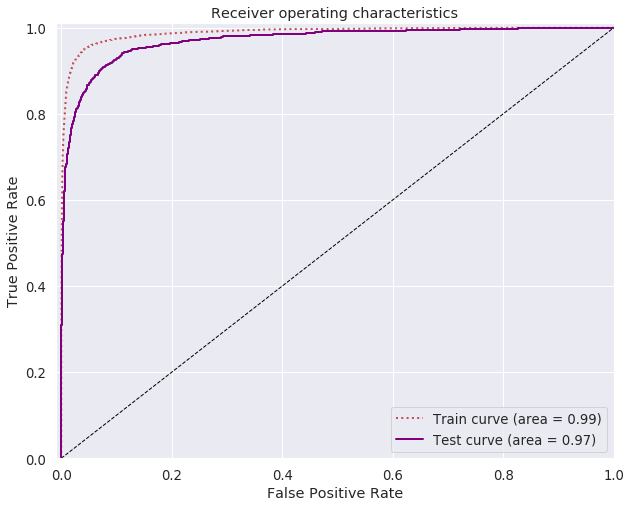

In [79]:
plt.figure(figsize=(10, 8), facecolor="white")
lw = 2
plt.grid(True)
plt.plot(fpr_xgb, tpr_xgb, "r:",
         lw=lw, label='Train curve (area = %0.2f)' % train_roc)
plt.plot(fpr_xgb_t, tpr_xgb_t, color="Purple",
         lw=lw, label='Test curve (area = %0.2f)' % test_roc)
plt.plot([0, 1], [0, 1], color='black', lw=1, linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristics')
plt.legend(loc="lower right")
plt.rcParams.update({'font.size': 16})
plt.show()

In [80]:
from sklearn.metrics import confusion_matrix
y_pred =(y_scores_xgb_test>0.9)
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[7020   46]
 [ 438  754]]


In [81]:
# df_docked.drop(['docked'], axis=1, inplace=True)
# df_docked.describe()

In [82]:
df_docked_small = df_docked[['rmsd', 'dG_separated', 'side1_score',
                           'dG_separated/dSASAx100', 'hbonds_int']]

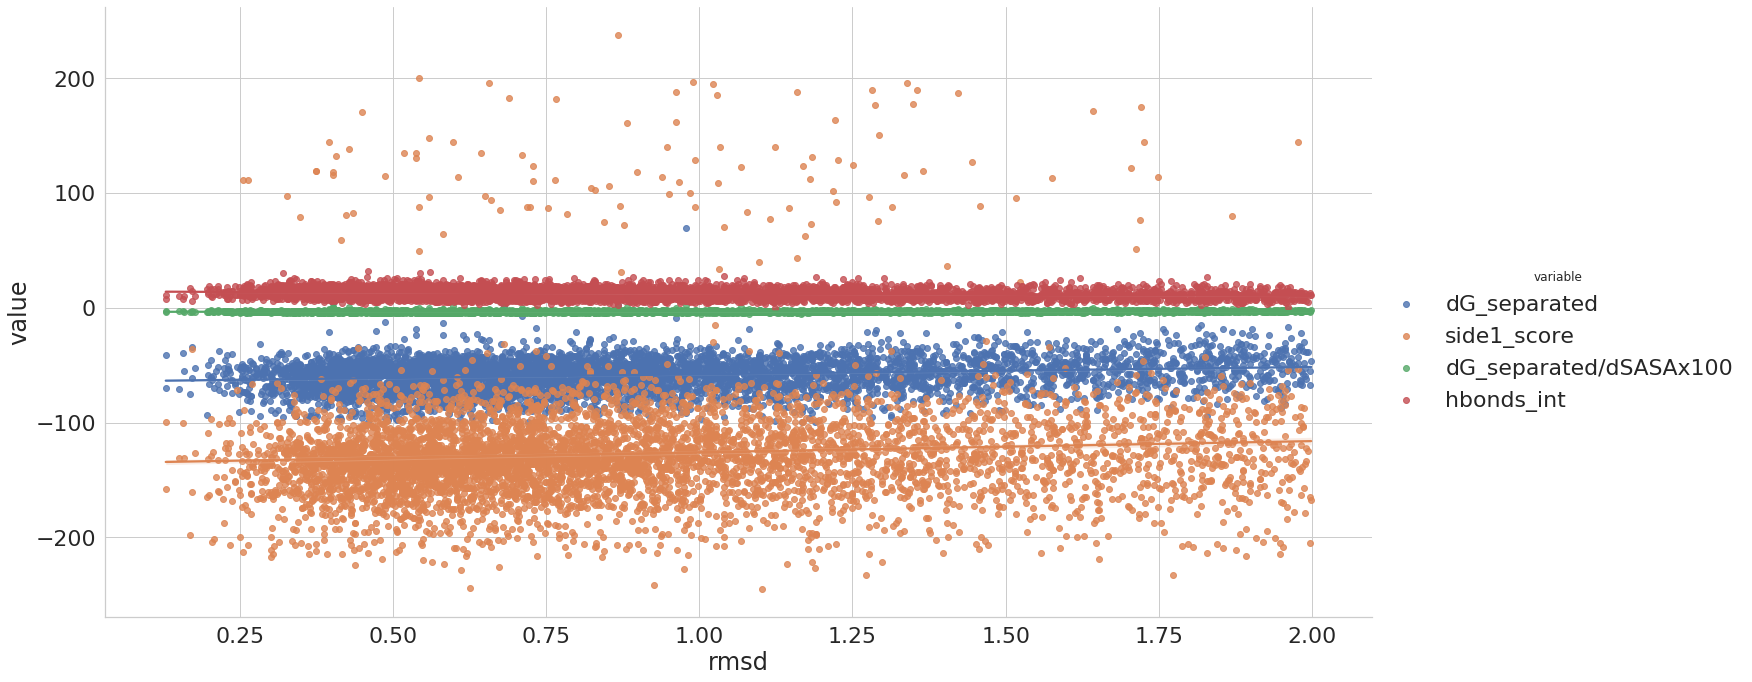

In [83]:
sns.set(font_scale=2)
sns.set_style("whitegrid")
sns.lmplot('rmsd', 'value', hue='variable', sharey=False,
           fit_reg=True, height=10, aspect=2, 
           data=pd.melt(df_docked_small, ['rmsd']))


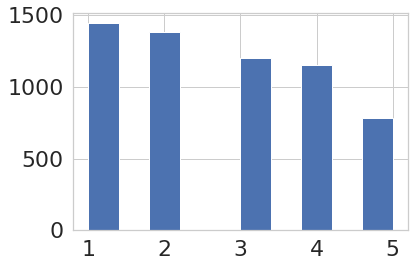

In [84]:
df_docked = df_docked.copy()
df_docked.reset_index(drop=True, inplace=True)
df_docked['rmsd_cat'] = pd.cut(df_docked['rmsd'], bins = [0.0, 0.55, 0.75, 1.0, 1.45, np.inf], labels=[1, 2, 3, 4, 5])
df_docked['rmsd_cat'].hist()
df_docked.dropna(inplace=True)

In [85]:
df_docked.describe()

,zrank,ProQ2D,ProQRosCenD,ProQRosFAD,ProQ3D,rmsd,complex_normalized,dG_separated,dG_separated/dSASAx100,dSASA_hphobic,...,hbond_lr_bb,hbond_bb_sc,hbond_sc,dslf_fa13,omega,fa_dun,p_aa_pp,yhh_planarity,rama_prepro,total_score
count,5962.000000,5962.000000,5962.000000,5962.000000,5962.000000,5962.000000,5962.000000,5962.000000,5962.000000,5962.000000,...,5962.000000,5962.000000,5962.000000,5962.000000,5962.000000,5962.000000,5962.000000,5962.000000,5962.000000,5962.000000
mean,-79.759579,0.444393,0.497641,0.951008,0.676536,0.883933,-3.707421,-58.675284,-3.290130,945.080488,...,-184.712510,-108.313509,-82.330598,-3.317513,25.962140,625.213775,-179.419166,1.780351,-12.696700,-1546.426169
std,14.895186,0.088658,0.134062,0.031353,0.086417,0.423815,0.195509,13.669977,0.594472,201.515304,...,55.836407,37.518298,21.684887,2.575303,15.605580,182.438139,51.122595,0.790239,32.827027,402.459539
min,-164.619000,0.238678,0.173534,0.785012,0.368619,0.129567,-4.193901,-99.511589,-5.170428,401.621063,...,-399.024253,-241.104800,-166.694992,-22.991620,1.259417,365.613509,-376.636318,0.204415,-95.480835,-2860.884837
25%,-87.567700,0.370155,0.387596,0.936922,0.610014,0.557779,-3.849305,-67.650152,-3.676371,797.921356,...,-212.806283,-131.761719,-95.766910,-4.549070,15.221455,483.337815,-209.685619,1.200313,-36.501026,-1752.083786
50%,-77.518850,0.437933,0.513773,0.957968,0.685770,0.779375,-3.735985,-57.593300,-3.323254,910.782928,...,-177.572060,-102.903181,-80.616937,-2.766932,21.701473,592.559442,-166.068183,1.649611,-15.646405,-1491.281685
75%,-69.491050,0.514682,0.616499,0.973173,0.741328,1.138314,-3.569022,-50.001167,-2.950125,1069.422028,...,-132.758551,-76.743387,-63.884203,-1.467846,31.654676,720.742516,-136.728917,2.212897,5.241748,-1217.594078
max,-45.754400,0.682593,0.745016,0.993919,0.883445,1.998340,-2.032987,69.119659,2.601760,1741.232788,...,-103.857152,-48.270387,-40.121032,1.661412,159.006257,1220.475552,-106.968476,5.139255,203.113946,-733.772026


In [86]:
split2 = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split2.split(df_docked, df_docked['rmsd_cat']):
        strat_train_set_d = df_docked.iloc[train_index]
        strat_test_set_d = df_docked.iloc[test_index]

In [87]:
print(strat_train_set_d.rmsd_cat.value_counts()/ len(strat_train_set_d))
print(strat_test_set_d.rmsd_cat.value_counts()/ len(strat_test_set_d))

1    0.241979
2    0.231705
3    0.201719
4    0.193542
5    0.131055
Name: rmsd_cat, dtype: float64
1    0.242246
2    0.232188
3    0.201174
4    0.193630
5    0.130763
Name: rmsd_cat, dtype: float64


In [88]:
for set_ in (strat_train_set_d, strat_test_set_d):
    set_.drop('rmsd_cat', axis=1, inplace=True)

/home/drewaight/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [89]:
# X_train_prep_d = strat_train_set_d.drop("rmsd", axis=1)
# y_train_d = strat_train_set_d["rmsd"].copy()
# X_test_prep_d = strat_test_set_d.drop("rmsd", axis=1)
# y_test_d = strat_test_set_d["rmsd"].copy()

In [90]:
X_train_d = strat_train_set_d.drop("rmsd", axis=1)
y_train_d = strat_train_set_d["rmsd"].copy()
X_test_d = strat_test_set_d.drop("rmsd", axis=1)
y_test_d = strat_test_set_d["rmsd"].copy()

In [91]:
X_train_d.columns

Index(['zrank', 'ProQ2D', 'ProQRosCenD', 'ProQRosFAD', 'ProQ3D',
       'complex_normalized', 'dG_separated', 'dG_separated/dSASAx100',
       'dSASA_hphobic', 'dSASA_int', 'dSASA_polar', 'delta_unsatHbonds',
       'hbond_E_fraction', 'hbonds_int', 'nres_int', 'per_residue_energy_int',
       'sc_value', 'side1_normalized', 'side1_score', 'side2_normalized',
       'side2_score', 'fa_atr', 'fa_rep', 'fa_sol', 'fa_intra_rep',
       'fa_intra_sol_xover4', 'lk_ball_wtd', 'fa_elec', 'pro_close',
       'hbond_sr_bb', 'hbond_lr_bb', 'hbond_bb_sc', 'hbond_sc', 'dslf_fa13',
       'omega', 'fa_dun', 'p_aa_pp', 'yhh_planarity', 'rama_prepro',
       'total_score', 'docked'],
      dtype='object')

In [92]:
# X_train_d = ss.fit_transform(X_train_prep_d)
# X_test_d = ss.fit_transform(X_test_prep_d)

In [93]:
from xgboost import XGBRegressor

xgb_reg = XGBRegressor(n_jobs=16)
xgb_reg.fit(X_train_d, y_train_d)

ValueError: DataFrame.dtypes for data must be int, float or bool.
                Did not expect the data types in fields docked

In [ ]:
def display_scores(scores):
    print('Scores:', scores)
    print('Mean:', scores.mean())
    print('Standard deviation:', scores.std())

In [ ]:
# xgbr_scores = cross_val_score(xgb_reg, X_train_d, y_train_d, scoring="neg_mean_squared_error", cv=10)
# xgbr_rmse_scores = np.sqrt(-xgbr_scores)
# display_scores(xgbr_rmse_scores)

In [ ]:
xgb_reg_parameters = {'nthread':[16], #when use hyperthread, xgboost may become slower
                        'objective':['reg:linear'],
                        'booster':[None, 'gblinear'],
                        'learning_rate': [0.05, 0.02], #so called `eta` value
                        'max_depth': [5],
                        'n_estimators': [600, 800],
                        'min_child_weight': [4,6],
                        'silent': [1],
                        'subsample': [0.7, 0.5],
                        'colsample_bytree': [0.7]}

In [ ]:
xgb_reg_grid = GridSearchCV(xgb_reg, xgb_reg_parameters,
                        cv = 10, n_jobs = 16, verbose=True)

xgb_reg_grid.fit(X_train_d, y_train_d)

In [ ]:
# final_xgb_reg = XGBRegressor(base_score=0.5, colsample_bylevel=1,
#                              colsample_bynode=1, colsample_bytree=0.7, gamma=0, gpu_id=-1,
#                              importance_type='gain', interaction_constraints=None,
#                              learning_rate=0.05, max_delta_step=0, max_depth=5,
#                              min_child_weight=4, monotone_constraints=None,
#                              n_estimators=800, n_jobs=16, nthread=16, num_parallel_tree=1,
#                              objective='reg:linear', random_state=0, reg_alpha=0, reg_lambda=1,
#                              scale_pos_weight=1, silent=1, subsample=0.5, tree_method=None,
#                              validate_parameters=False, verbosity=None)
# final_xgb_reg.fit(X_train_d, y_train_d)

In [ ]:
# cvres = xgb_reg_grid.cv_results_
# # for key, value in xgb_reg_grid.cv_results_.items() :
# #     print (key)

# for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
#     print(mean_score, params)

In [ ]:
final_xgb_reg = xgb_reg_grid.best_estimator_
xgb_reg_grid.best_estimator_

In [ ]:
pickle.dump(final_xgb_reg, open("xgb_regress.dat", "wb"))

In [ ]:
import pickle
final_xgb_reg_loaded = pickle.load(open("xgb_regress.dat", "rb"))
print(final_xgb_reg_loaded)

In [ ]:
f_xgbr_scores = cross_val_score(final_xgb_reg_loaded, X_train_d, y_train_d, scoring="neg_mean_squared_error", cv=10)
f_xgbr_rmse_scores = np.sqrt(-f_xgbr_scores)
display_scores(f_xgbr_rmse_scores)

In [ ]:
from sklearn.model_selection import cross_val_predict
predicted_train = cross_val_predict(final_xgb_reg_loaded, X_train_d, y_train_d, cv=10)

In [ ]:
fig, ax = plt.subplots()
ax.scatter(y_train_d, predicted_train, edgecolors=(0, 0, 0))
ax.plot([y_train_d.min(), y_train_d.max()], [y_train_d.min(), y_train_d.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

In [ ]:
xgbr_scores = cross_val_score(final_xgb_reg_loaded, X_test_d, y_test_d, scoring="neg_mean_squared_error", cv=10)
xgbr_rmse_scores = np.sqrt(-xgbr_scores)
display_scores(xgbr_rmse_scores)

In [ ]:
predicted_test = cross_val_predict(final_xgb_reg_loaded, X_test_d, y_test_d, cv=10)

In [ ]:
fig, ax = plt.subplots()
ax.scatter(y_test_d, predicted_test, edgecolors=(0, 0, 0))
ax.plot([y_test_d.min(), y_test_d.max()], [y_test_d.min(), y_test_d.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

In [ ]:
train_df = pd.DataFrame({'Measured':y_train_d, 'Predicted':predicted_train})
train_df['Data'] = "Train"

test_df = pd.DataFrame({'Measured':y_test_d, 'Predicted':predicted_test})
test_df['Data'] = "Test"

reg_df = pd.concat([train_df, test_df], ignore_index=True)
sns.set_style("darkgrid")
# sns.set()
# current_palette = sns.color_palette("Paired", 6)
# sns.set_palette(current_palette)
flatui = ["#FFC000", "#FF00FF"]
g = sns.lmplot('Measured', 'Predicted', hue='Data',
       fit_reg=True, height=8, aspect=1.5,  
       data=reg_df, palette=flatui,
       scatter_kws={'alpha':0.6, "s": 40, 'edgecolor':'k', 'linewidth':0.75})

x0, x1 = g.ax.get_xlim()
y0, y1 = g.ax.get_ylim()
lims = [max(x0, y0), min(x1, y1)]
g.ax.plot(lims, lims, ':k', lw=3)   
g.ax.set_xticks(np.arange(0.2, 2.2, step=0.2))
g.ax.set_yticks(np.arange(0.4, 2.2, step=0.2))

In [ ]:
final_xgb_reg_loaded.feature_names = list(X_train.columns)
final_xgb_reg_loaded.get_booster().feature_names = final_xgb_reg_loaded.feature_names

In [ ]:
fnum = 15
booster = final_xgb_reg_loaded.get_booster()
gain = booster.get_score(importance_type="gain")
gain_top = pd.DataFrame([OrderedDict(sorted(gain.items(), key=lambda x: x[1], reverse=True)[:fnum])])
weight = booster.get_score(importance_type="weight")
weight_top = pd.DataFrame([OrderedDict(sorted(weight.items(), key=lambda x: x[1], reverse=True)[:fnum])])
cover = booster.get_score(importance_type="cover")
cover_top = pd.DataFrame([OrderedDict(sorted(cover.items(), key=lambda x: x[1], reverse=True)[:fnum])])

In [ ]:
sns.set(font_scale=1.2)
f, ax = plt.subplots(figsize=(12, 6), facecolor="white")
ax.set(xlabel='F-Score')
plt.title('Feature Plot Gain')
sns.barplot(data=gain_top, orient='h')
for p in ax.patches:
    width = p.get_width()
    ax.text(width -0.01,
            p.get_y()+p.get_height()/2. + 0.28,
            '{:1.2f}'.format(width),
            ha="center")

In [ ]:
f, ax = plt.subplots(figsize=(12, 6), facecolor="white")
ax.set(xlabel='F-Score')
plt.title('Feature Plot Weight')
sns.barplot(data=weight_top, orient='h')
for p in ax.patches:
    width = p.get_width()
    ax.text(width -50.5  ,
            p.get_y()+p.get_height()/2. + 0.28,
            '{:1.0f}'.format(width),
            ha="center")